## Vectorization

In [77]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

### 1. Load Data

#### Open-ended Answers

In [78]:
activities = pd.read_csv('./data/activities.csv')

In [79]:
health = pd.read_csv('./data/health.csv')

In [80]:
home_safety = pd.read_csv('./data/home_safety.csv')

In [81]:
quantity_learning = pd.read_csv('./data/quantity_learning.csv')

In [82]:
radio_lessons = pd.read_csv('./data/radio_lessons.csv')

## 2. Count vectorization function
#### 2.1. Retrieve bi/trigrams tokens, refine and encode

In [83]:
stopwords = stopwords.words('english')

In [84]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [85]:
def bow_vectorization(data, index, n_grams):
    vectorizer = CountVectorizer(stop_words = stopwords, lowercase = True, strip_accents='unicode', ngram_range=n_grams, preprocessor=removal)
    data_tokens = vectorizer.fit_transform(data)
    print(len(vectorizer.vocabulary_),'words in dictionary.')
    return pd.DataFrame(data_tokens.todense(), columns=vectorizer.get_feature_names(), index=index)

#### 2.2. Search word in vocabulary

In [86]:
def search(word_in=None, word_out=None, vocabulary=None):
    if word_in is None:
        return 'no words to search'

    words = []
    if isinstance(word_in, list):
        for word in word_in:
            for term in vocabulary:
                if word in term:
                    words.append(term)            
    else:
        for term in vocabulary:
            if word_in in term:
                words.append(term)
    
    words_clean = []
    if word_out:
        if isinstance(word_out,str):
            word_out = [word_out]
        print(word_out)
        for word in word_out:
            for term in words:
                if word in term:
                    pass
                else:
                    words_clean.append(term)
        return words_clean
    else:
        return words

## 3. Questions to vectorize

### 3.1. Are you doing other things at home to learn, aside from radio lessons? What are you doing?

Only those who answered "Yes" explained later what they were doing.

In [108]:
# Yes answer
activities[activities.iloc[:,1] == 'Yes'].notnull().sum()

Unnamed: 0                                                                    1499
Q34_Are you doing other things at home to learn, aside from radio lessons?    1499
Q35_What are you doing?                                                       1499
dtype: int64

In [109]:
# No answer
activities[activities.iloc[:,1] == 'No'].notnull().sum()

Unnamed: 0                                                                    1011
Q34_Are you doing other things at home to learn, aside from radio lessons?    1011
Q35_What are you doing?                                                          0
dtype: int64

Counting random words

In [110]:
mask = activities.iloc[:,2].str.contains('read|Read', na=False)
mask.sum()

691

In [111]:
mask_2 = activities.iloc[:,2].str.contains('work|Work', na=False)
mask_2.sum()

109

In [112]:
mask_3 = activities.iloc[:,2].str.contains('Harvest|harvest|culti|Cultiv', na=False)
mask_3.sum()

32

In [113]:
mask_4 = activities.iloc[:,2].str.contains('package', na=False)
mask_4.sum()

60

#### Word vectorization

In [114]:
activities_bi = bow_vectorization(data = activities.iloc[:,2].dropna(), 
                                  index=activities.iloc[:,2].dropna().index, 
                                  n_grams=(1, 1))

456 words in dictionary.


In [115]:
# see 25 most repeated
activities_bi.sum().sort_values(ascending=False)[:25]

reading       595
books         314
notes         132
revising      106
home           96
work           92
read           88
studies        87
studying       76
previous       74
revision       69
cooking        63
study          59
school         55
text           53
textbooks      51
holiday        45
revise         42
group          41
package        37
lessons        36
exercise       32
discussion     32
time           30
book           30
dtype: int64

#### Group words
Group similar words by concepts and count unique apperance

In [127]:
studying = activities_bi[['revise','revised','revising','revision','reading','read', 'book', 'books','note','notes','english',
               'math','maths','mathematics','study','studying','studies', 'science', 'subjects', 'revisions',
              'text', 'textbook','textbooks','homework','practicing','lessons', 'practing', 'lessons','lesson',
              'exercise','exercises','discuss','discussion','discussing','activities']]

In [130]:
housework = activities_bi[['domestic','garden','water','housework','cooking','fetching', 'firewood','collect','cattle',
                           'fetch','household','cleaning','washing','wash','utensils','clothes','clean','chores']]

In [131]:
holiday_package = activities_bi[['holiday','package','packages','holidays','holydays','holyday']]

KeyError: "['holidays', 'holyday'] not in index"

In [126]:
external_work = activities_bi[['harvest', 'harvesting','cultivation','caltivation','goat','goats','looking','farm','farming']]

In [120]:
leisure = activities_bi[['play', 'ball','foot ball','soccer']]

In [121]:
others = activities_bi.drop(studying.columns.tolist() + \
            housework.columns.tolist() + \
            holiday_package.columns.tolist() + \
            external_work.columns.tolist() + \
            leisure.columns.tolist(), axis=1)

Count one per concept apperance (not word)

In [101]:
studying = studying.sum(axis=1)
housework = housework.sum(axis=1)
holiday_package = holiday_package.sum(axis=1)
external_work = external_work.sum(axis=1)
leisure = leisure.sum(axis=1)
others = others.sum(axis=1)

In [102]:
studying[studying != 0] = 1
housework[housework != 0] = 1
holiday_package[holiday_package != 0] = 1
external_work[external_work != 0] = 1
others[others != 0] = 1

In [103]:
study = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['studying'])
study.loc[studying[studying == 1].index,:] = 1
house = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['housework'])
house.loc[housework[housework == 1].index,:] = 1
holiday = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['holiday_package'])
holiday.loc[holiday_package[holiday_package == 1].index,:] = 1
external = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['external_work'])
external.loc[external_work[external_work == 1].index,:] = 1
leisure_time = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['leisure'])
leisure_time.loc[leisure[leisure == 1].index,:] = 1
others_w = pd.DataFrame(np.zeros(activities.shape[0]), dtype=int, columns=['others'])
others_w.loc[others[others == 1].index,:] = 1

In [104]:
activities_group = pd.concat([study,house,holiday,external,leisure_time,others_w], axis=1)

Visualization

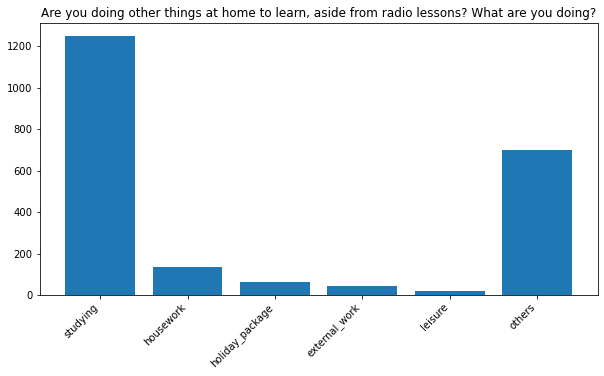

In [105]:
plt.figure(figsize=(10,5))
plt.bar(activities_group.columns,activities_group.sum())
plt.title('Are you doing other things at home to learn, aside from radio lessons? What are you doing?')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Save vectors and concepts

In [30]:
activities_bi.to_csv('data/tokens/activities.csv')
activities_group.to_csv('data/concepts/activities_concepts.csv')

### 3.2. Do you feel worried about your health due to studying/being at home during COVID-19? Why or why not?

In [132]:
health.iloc[:,1].value_counts()

Yes         772
No          528
Somewhat     75
Name: Q46_Do you feel worried about your health due to studying/being at home during COVID-19?, dtype: int64

Get 'Yes' and 'No' answers

In [133]:
# health_yes = health[(health.iloc[:,1] == 'Yes') | (health.iloc[:,1] == 'Somewhat')].iloc[:,2]
health_yes = health[(health.iloc[:,1] == 'Yes')].iloc[:,2]

In [134]:
health_no = health[health.iloc[:,1] == 'No'].iloc[:,2]

#### Bigram vectorization
Worry about studying at home

In [135]:
health_yes_bi = bow_vectorization(data = health_yes.dropna(), 
                                  index= health_yes.dropna().index,
                                  n_grams=(2, 4))

2666 words in dictionary.


In [136]:
health_yes_bi.sum().sort_values(ascending=False)[:60]

corona virus                    33
want live                       22
covid infection                 22
lot things                      14
among people                    13
infection among people          12
infection among                 12
missing lot                     12
missing lot things              12
covid infection among people    11
covid infection among           11
staying home                    10
deadly disease                   9
schools closed                   8
kills people                     7
social distancing                7
fear covid                       7
many people                      6
worried covid                    6
want infected                    6
virus dangerous                  6
dangerous disease                6
study well                       6
disease every                    5
corona virus dangerous           5
kill people                      5
fear corona                      5
covid disease                    5
safe home           

#### Group Bigrams
Bigrams about the disease

In [152]:
affect = search('affect',None, health_yes_bi.columns)
len(affect)

84

In [153]:
# get list of bigrams with "covid"
covid = search(['covid','kill','die'], None, health_yes_bi.columns)
len(covid)

395

In [154]:
# get list of bigrams with "disease"
disease = search('disease', None, health_yes_bi.columns)
len(disease)

246

In [155]:
# get list of bigrams with "pandemic"
pandemic = search('pandemic', None, health_yes_bi.columns)
len(pandemic)

24

In [156]:
# get list of bigrams with "corona"
corona = search('corona', None, health_yes_bi.columns)
len(corona)

165

In [157]:
# get list of bigrams with "infection"
infection = search(['infect','contract'], None, health_yes_bi.columns)
len(infection)

172

In [158]:
# get list of bigrams with "virus"
virus = search('virus', None, health_yes_bi.columns)
len(virus)

151

Bigrams about the waste of time

In [159]:
interrupted = search(['interr','education'], None, health_yes_bi.columns)
len(interrupted)

30

In [160]:
enough = search('enough', 'affect', health_yes_bi.columns)
len(enough)
#health_yes[health_yes.str.contains('enough')].to_list()

['affect']


23

In [161]:
children = search('children', ['covid','coron'], health_yes_bi.columns)
len(children)

['covid', 'coron']


123

In [162]:
# get list of bigrams with "lot"
lot = search('lot', 'coro', health_yes_bi.columns)
len(lot)

['coro']


57

In [163]:
# get list of bigrams with "things"
things = search('thing', None, health_yes_bi.columns)
len(things)

81

In [164]:
# get list of bigrams with "miss"
miss = search('missing', None, health_yes_bi.columns)
len(miss)

21

In [165]:
# get list of bigrams with "time"
time = search('time', None, health_yes_bi.columns)
len(time)

116

In [166]:
# get list of bigrams with "bore"
bore = search('bore', None, health_yes_bi.columns)
len(bore)

5

In [167]:
# get list of bigrams with "idle"
idle = search('idle', None, health_yes_bi.columns)
len(idle)

15

In [168]:
# get list of bigrams with "active"
active = search('active', None, health_yes_bi.columns)
len(active)

15

In [169]:
# get list of bigrams with "closed"
closed = search('closed', None, health_yes_bi.columns)
len(closed)

38

In [170]:
learn = search('learn', ['covid','viru','corona','infect'], health_yes_bi.columns)
len(learn)

['covid', 'viru', 'corona', 'infect']


271

Bigrams about health at home

In [171]:
# get list of bigrams with "home"
home = search('home', None, health_yes_bi.columns)

Count one per concept apperance (not word)

In [172]:
fear_covid = health_yes_bi[list(set(covid+disease+infection+corona+virus+pandemic+affect))]

In [173]:
safe_home = health_yes_bi[home]

In [174]:
miss_school = health_yes_bi[list(set(things+miss+bore+idle+active+learn+closed+lot+enough+children+interrupted))]

The rest of the Bigrams

In [175]:
other = health_yes_bi.drop(fear_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [179]:
#other.columns.to_list()

In [60]:
fear_covid = fear_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
other = other.sum(axis=1)

In [61]:
fear_covid[fear_covid != 0] = 1
safe_home[safe_home != 0] = 1
miss_school[miss_school != 0] = 1
other[other != 0] = 1

In [62]:
fear_c = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear_covid'])
fear_c.loc[fear_covid[fear_covid == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe_home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['miss_school'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['other_w'])
other_w.loc[other[other == 1].index,:] = 1

In [63]:
health_yes_group = pd.concat([fear_c,safe_h,miss,other_w], axis=1)

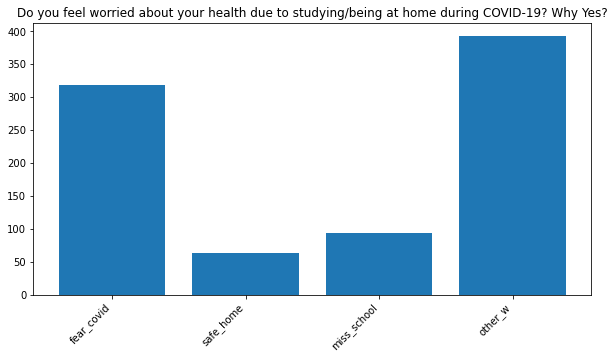

In [64]:
plt.figure(figsize=(10,5))
plt.bar(health_yes_group.columns,health_yes_group.sum())
plt.title('Do you feel worried about your health due to studying/being at home during COVID-19? Why Yes?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [65]:
health_yes_group.sum() / health_yes_group.sum(axis=1).sum()

fear_covid     0.366667
safe_home      0.073563
miss_school    0.108046
other_w        0.451724
dtype: float64

#### Concepts gathering from dataset
Waste of time

In [66]:
things = health_yes.str.contains('thing')

In [67]:
miss = health_yes.str.contains('miss')

In [68]:
time = health_yes.str.contains('time')

In [69]:
active = health_yes.str.contains('active')

In [70]:
idle = health_yes.str.contains('idle')

In [71]:
tire = health_yes.str.contains('tire')

In [72]:
waste = health_yes.str.contains('wast')

In [73]:
learn = (health_yes.str.contains('learn') & ~health_yes.str.contains('covid|Covid'))

Covid

In [74]:
covid_home = (health_yes.str.contains('home')) & (health_yes.str.contains('covid|virus|disease|corona'))
spread_home = (health_yes.str.contains('home')) & (health_yes.str.contains('people|visitor|com|inter|crow'))

In [75]:
idleness = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['idleness'])
idleness.iloc[health_yes[things | time | miss | active | idle | tire | waste].index] = 1
idleness.sum()

idleness    55
dtype: int64

In [76]:
#fear_home = health_yes[covid_home | spread_home]
fear_home = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear home'])
fear_home.iloc[health_yes[covid_home | spread_home].index] = 1
fear_home.sum()

fear home    25
dtype: int64

In [77]:
# fear_outside = health_yes[health_yes.str.contains('Covid|covid|coron|Coron|infection|viru|Vir')]
fear_outside = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['fear outside'])
fear_outside.iloc[health_yes[health_yes.str.contains('Covid|covid|coron|Coron|infection|viru|Vir')].index] = 1
fear_outside.sum()

fear outside    227
dtype: int64

In [78]:
health_yes_words = pd.concat([idleness, fear_home, fear_outside], axis=1)
health_yes_words.columns = ['idleness','fear home','fear outside']

In [79]:
health_yes_words.sum() / health_yes_group.shape[0]

idleness        0.011635
fear home       0.005289
fear outside    0.048022
dtype: float64

#### Bigram vectorization
Not worry about studying at home

In [80]:
health_no_bi = bow_vectorization(data = health_no.dropna(), 
                                  index= health_no.dropna().index,
                                  n_grams=(2, 4))

1514 words in dictionary.


In [81]:
health_no_bi.sum().sort_values(ascending=False)[:26]

safe home                        56
home safe                        34
stay home                        24
feel safe                        19
staying home                     16
preventive measures              13
feel safe home                   13
home stay                        13
home stay safe                   12
staying home safe                12
stay safe                        12
stay home stay                   11
able protect                     10
stay home stay safe              10
home safety                       9
social distance                   9
preventives measures              9
social distancing                 7
following preventive              7
following preventive measures     6
safe healthy                      6
protect self                      6
protect covid                     5
wash hands                        5
contact people                    5
home safe healthy                 4
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [82]:
# get list of bigrams with "covid"
safe_covid = search('covid', 'home', health_no_bi.columns)
len(safe_covid)

['home']


123

In [83]:
# get list of bigrams with "disease"
safe_disease = search('disease', 'home', health_no_bi.columns)
len(safe_disease)
#health_no[health_no.str.contains('disease')].tolist()

['home']


43

In [84]:
# get list of bigrams with "pandemic"
safe_pandemic = search('pandemic', 'home', health_no_bi.columns)
len(pandemic)
#health_no[health_no.str.contains('pandemic')].tolist()

['home']


24

In [85]:
# get list of bigrams with "corona"
safe_corona = search('corona', 'home', health_no_bi.columns)
len(corona)

['home']


165

In [86]:
# get list of bigrams with "infection"
safe_infection = search('infection', 'home', health_no_bi.columns)
len(infection)

['home']


172

In [87]:
# get list of bigrams with "virus"
safe_virus = search('virus', 'home', health_no_bi.columns)
len(safe_virus)

['home']


18

Bigrams about feeling safe (in/outside Home)

In [88]:
prevention = search(['foll', 'hand', 'measu'], None, health_no_bi.columns)
len(prevention)

234

In [89]:
feel = search('feel', 'worr', health_no_bi.columns)
len(feel)
#health_no[health_no.str.contains('home')].tolist()

['worr']


30

In [90]:
safe_home = search('home', 'safe', health_no_bi.columns)
len(safe_home)

['safe']


225

In [91]:
safe = search('safe', 'home', health_no_bi.columns)
len(safe)

['home']


48

Bigrams about the waste of time

In [92]:
# get list of bigrams with "things"
things = search('thing', None, health_no_bi.columns)
len(things)
#health_no[health_no.str.contains('thing')].tolist()

23

In [93]:
# get list of bigrams with "miss"
miss = search('miss', None, health_no_bi.columns)
len(miss)

13

In [94]:
# get list of bigrams with "time"
time = search('time', None, health_no_bi.columns)
len(time)

15

In [95]:
# get list of bigrams with "lot"
lot = search('lot', None, health_no_bi.columns)
len(lot)

18

In [96]:
go_back = search('back', None, health_no_bi.columns)
len(go_back)

6

Count one per concept apperance (not word)

In [97]:
safe_covid = health_no_bi[list(set(safe_covid+safe_disease+safe_infection+safe_corona+safe_virus+safe_pandemic))]

In [98]:
safe_home = health_no_bi[list(set(safe_home+safe+feel+prevention))]

In [99]:
miss_school = health_no_bi[list(set(things+miss+time+lot+go_back))]

The rest of the Bigrams

In [100]:
other = health_no_bi.drop(safe_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)
test_other = health_no_bi.drop(safe_covid.columns.to_list() + safe_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [101]:
safe_covid = safe_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
other = other.sum(axis=1)

In [102]:
safe_covid[safe_covid != 0] = 1
safe_home[safe_home != 0] = 1
miss_school[miss_school != 0] = 1
other[other != 0] = 1

In [103]:
safe_c = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe_covid'])
safe_c.loc[safe_covid[safe_covid == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['safe_home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['miss_school'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(health.shape[0]), dtype=int, columns=['other_w'])
other_w.loc[other[other == 1].index,:] = 1

In [104]:
health_no_group = pd.concat([safe_c,safe_h,miss,other_w], axis=1)

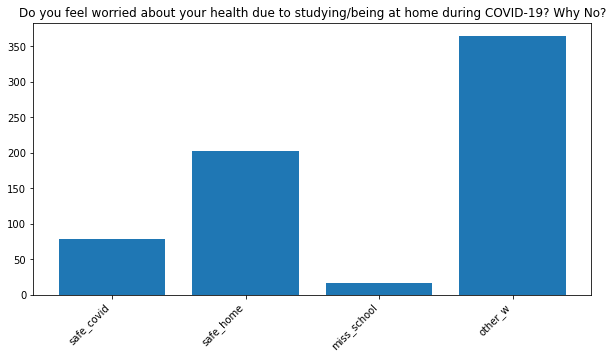

In [105]:
plt.figure(figsize=(10,5))
plt.bar(health_no_group.columns, health_no_group.sum())
plt.title('Do you feel worried about your health due to studying/being at home during COVID-19? Why No?')
plt.xticks(rotation=45, ha='right')
plt.show()

In [106]:
health_no_group.sum() / health_no_group.sum(axis=1).sum()

safe_covid     0.119155
safe_home      0.306184
miss_school    0.024133
other_w        0.550528
dtype: float64

#### Concepts gathering from Dataset
Feeling safe

In [107]:
health_yes_group = pd.concat([fear_c,safe_h,miss,other_w], axis=1)

In [108]:
safe_covid = health_no.str.contains('covid')
safe_covid.sum()

21

In [109]:
safe_home = health_no.str.contains('home')
safe_home.sum()

190

In [110]:
safe = health_no.str.contains('safe') & ~health_no.str.contains('home')
safe.sum()

43

Waste time

In [111]:
nothing = health_no.str.contains('thing')
nothing.sum()

8

In [112]:
waste = health_no.str.contains('lot')
waste.sum()

4

In [113]:
go_back = (health_no.str.contains('school')) & (health_no.str.contains('go'))
go_back.sum()

2

#### Save vectors and concepts

In [114]:
# tokens
health_yes_bi.to_csv('data/tokens/health_home_yes.csv')
health_no_bi.to_csv('data/tokens/health_home_no.csv')
# concepts
health_yes_group.to_csv('data/concepts/health_yes_concepts.csv')
health_no_group.to_csv('data/concepts/health_no_concepts.csv')

### 3.3. Do you feel worried about your safety due to being at home during COVID-19? Why or why not?

In [115]:
home_safety.iloc[:,1].value_counts()

Yes         666
No          648
Somewhat     61
Name: Q48_Do you feel worried about your safety due to being at home during COVID-19?, dtype: int64

Group 'Yes' and 'Somewhat' answers and separate them from the negative answers

In [116]:
home_safety_yes = home_safety[(home_safety.iloc[:,1] == 'Yes') | (home_safety.iloc[:,1] == 'Somewhat')].iloc[:,2]

In [117]:
home_safety_no = home_safety[home_safety.iloc[:,1] == 'No'].iloc[:,2]

#### Bigram vectorization
Worry about safety at home

In [118]:
home_safety_yes_bi = bow_vectorization(data = home_safety_yes.dropna(),
                                       index =  home_safety_yes.dropna().index,
                                       n_grams=(2, 3))

1936 words in dictionary.


In [119]:
home_safety_yes_bi.sum().sort_values(ascending=False)[:20]

corona virus           43
staying home           15
fear corona            14
disease affect         13
come home              12
fear corona virus      11
safe home              11
movements people       11
pandemic everywhere    11
fear disease           11
social distancing      10
affect everywhere      10
people home             9
want infected           9
feel safe               8
home safe               8
staying home safe       7
many people             7
feel safe home          7
dangerous disease       7
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [120]:
# get list of bigrams with "covid"
covid = search('covid', 'home', home_safety_yes_bi.columns)
len(covid)

['home']


128

In [121]:
# get list of bigrams with "disease"
disease = search('disease', 'home', home_safety_yes_bi.columns)
len(disease)
#health_no[health_no.str.contains('disease')].tolist()

['home']


117

In [122]:
# get list of bigrams with "pandemic"
pandemic = search('pandemic', 'home', home_safety_yes_bi.columns)
len(pandemic)
#health_no[health_no.str.contains('pandemic')].tolist()

['home']


33

In [123]:
# get list of bigrams with "corona"
corona = search('corona', None, home_safety_yes_bi.columns)
len(corona)

98

In [124]:
# get list of bigrams with "infection"
infection = search('infect', None, home_safety_yes_bi.columns)
len(infection)

78

In [125]:
# get list of bigrams with "virus"
virus = search('virus', None, home_safety_yes_bi.columns)
len(virus)

117

In [126]:
# get list of bigrams with "fear"
fear = search(['fear','death','kill'], 'home', home_safety_yes_bi.columns)
len(fear)

['home']


87

Bigrams about home and safety

In [127]:
worry_home = search('home', 'safe', home_safety_yes_bi.columns)
len(worry_home)

['safe']


190

In [128]:
safe_out = search('safe', ['home','fear','safe'], home_safety_yes_bi.columns)
len(safe_out)

['home', 'fear', 'safe']


115

In [129]:
safe_home = search(['home', 'safe'], None, home_safety_yes_bi.columns)
len(safe_home)

265

Bigrams about school

In [130]:
school = search('school', 'virus', home_safety_yes_bi.columns)
len(school)

['virus']


73

In [131]:
lots = search('lot', 'virus', home_safety_yes_bi.columns)
len(lots)

['virus']


40

In [132]:
miss = search('miss', 'virus', home_safety_yes_bi.columns)
len(miss)

['virus']


21

In [133]:
things = search('things', 'virus', home_safety_yes_bi.columns)
len(things)

['virus']


28

In [134]:
waste = search('waste', 'virus', home_safety_yes_bi.columns)
len(waste)

['virus']


12

In [135]:
lose = search(['lost','losing'], 'virus', home_safety_yes_bi.columns)
len(lose)

['virus']


16

In [136]:
time = search('time', ['virus','infect','diseas','worr','pandem'], home_safety_yes_bi.columns)
len(time)

['virus', 'infect', 'diseas', 'worr', 'pandem']


255

Count one per concept apperance (not word)

In [137]:
worry_covid = home_safety_yes_bi[list(set(covid+disease+infection+corona+virus+pandemic))]

In [138]:
safe_home = home_safety_yes_bi[list(set(safe_home))]

In [139]:
miss_school = home_safety_yes_bi[list(set(things+miss+lots+waste+lose+time))]

In [140]:
worry_home = home_safety_yes_bi[list(set(worry_home))]

The rest of the Bigrams

In [141]:
other = home_safety_yes_bi.drop(safe_home.columns.to_list() + worry_covid.columns.to_list() + worry_home.columns.to_list() + miss_school.columns.to_list(), axis=1)
test_other = home_safety_yes_bi.drop(safe_home.columns.to_list() + worry_covid.columns.to_list() + worry_home.columns.to_list() + miss_school.columns.to_list(), axis=1)

In [142]:
worry_covid = worry_covid.sum(axis=1)
worry_home = worry_home.sum(axis=1)
miss_school = miss_school.sum(axis=1)
safe_home = safe_home.sum(axis=1)
other = other.sum(axis=1)

In [143]:
worry_covid[worry_covid != 0] = 1
worry_home[worry_home != 0] = 1
miss_school[miss_school != 0] = 1
safe_home[safe_home != 0] = 1
other[other != 0] = 1

In [144]:
worry_c = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['worry covid'])
worry_c.loc[worry_covid[worry_covid == 1].index,:] = 1
worry_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['worry home'])
worry_h.loc[worry_home[worry_home == 1].index,:] = 1
miss = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['waste time'])
miss.loc[miss_school[miss_school == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['safe home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [145]:
home_safety_yes_group = pd.concat([worry_c,worry_h,miss,safe_h,other_w], axis=1)

Visualization

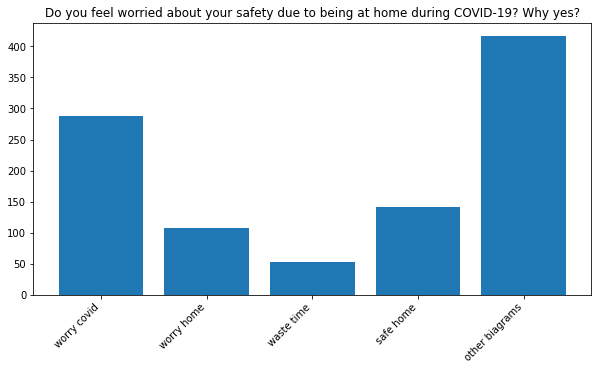

In [146]:
plt.figure(figsize=(10,5))
plt.bar(home_safety_yes_group.columns,home_safety_yes_group.sum())
plt.title('Do you feel worried about your safety due to being at home during COVID-19? Why yes?')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Bigram vectorization
Not Worried about safecty at home

In [147]:
home_safety_no_bi = bow_vectorization(data = home_safety_no.dropna(),
                                      index = home_safety_no.dropna().index,
                                      n_grams=(2, 3))

1252 words in dictionary.


In [148]:
home_safety_no_bi.sum().sort_values(ascending=False)[:25]

safe home                74
home safe                49
feel safe                34
social distancing        30
stay home                30
feel safe home           26
staying home             22
preventive measures      18
stay safe                17
safety measures          16
home stay                15
stay home stay           15
home stay safe           15
staying home safe        14
social distance          12
wash hands               10
home safety               9
safe healthy              9
home safe healthy         8
safety measures covid     7
washing hands             7
measures covid            7
take care                 6
come contact              5
following preventive      5
dtype: int64

#### Group Bigrams
Bigrams about the disease

In [149]:
no_fear_virus = search(['covid','disease','pandemic','corona','vir','infect','contra','fear','kill','dea'], 'home', home_safety_no_bi.columns)
len(no_fear_virus)

['home']


173

Bigrams about home and safety

In [150]:
no_fear_virus_home = search(['home', 'safe'], None, home_safety_no_bi.columns)
len(safe_home)

727

Bigrams about prevention

In [151]:
hands = search('hands', None, home_safety_no_bi.columns)
len(hands)

62

In [152]:
distance = search(['distance','social'], None, home_safety_no_bi.columns)
len(distance)
#home_safety_no[home_safety_no.str.contains('school')].to_list()

101

In [153]:
measures = search(['measures','prevent','precau','care','prot'], None, home_safety_no_bi.columns)
len(measures)

190

In [154]:
stay = search('stay', None, home_safety_no_bi.columns)
len(stay)

81

Count one per concept apperance (not word)

In [155]:
no_fear_covid = home_safety_no_bi[no_fear_virus]

In [156]:
safe_home = home_safety_no_bi[no_fear_virus_home]

In [157]:
prevention = home_safety_no_bi[list(set(hands + distance + stay))]

The rest of the Bigrams

In [158]:
other = home_safety_no_bi.drop(no_fear_covid.columns.to_list() + safe_home.columns.to_list() + prevention.columns.to_list(), axis=1)
test_other = home_safety_no_bi.drop(no_fear_covid.columns.to_list() + safe_home.columns.to_list() + prevention.columns.to_list(), axis=1)

In [159]:
no_fear_covid = no_fear_covid.sum(axis=1)
safe_home = safe_home.sum(axis=1)
prevention = prevention.sum(axis=1)
other = other.sum(axis=1)

In [160]:
no_fear_covid[no_fear_covid != 0] = 1
safe_home[safe_home != 0] = 1
prevention[prevention != 0] = 1
other[other != 0] = 1

In [161]:
n_f_c = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['no fear virus'])
n_f_c.loc[no_fear_covid[no_fear_covid == 1].index,:] = 1
prev = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['preventive measures'])
prev.loc[prevention[prevention == 1].index,:] = 1
safe_h = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['safe at home'])
safe_h.loc[safe_home[safe_home == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(home_safety.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [162]:
home_safety_no_group = pd.concat([n_f_c, prev, safe_h, other_w], axis=1)

Visualization

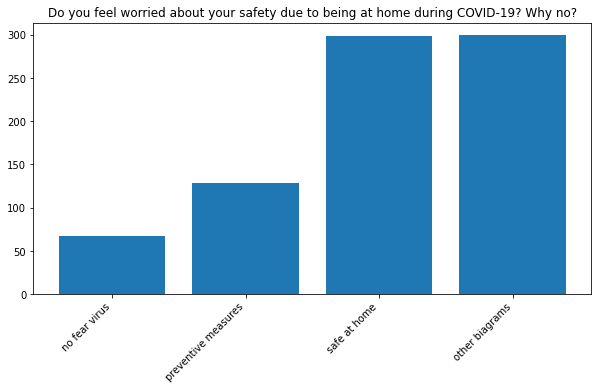

In [163]:
plt.figure(figsize=(10,5))
plt.bar(home_safety_no_group.columns, home_safety_no_group.sum())
plt.title('Do you feel worried about your safety due to being at home during COVID-19? Why no?')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Save vectors and concepts

In [164]:
# tokens
home_safety_yes_bi.to_csv('data/tokens/safety_home_yes.csv')
home_safety_no_bi.to_csv('data/tokens/health_home_no.csv')
# concepts
home_safety_yes_group.to_csv('data/concepts/safety_home_yes_concepts.csv')
home_safety_no_group.to_csv('data/concepts/health_home_no_concepts.csv')

### 3.4. Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures? Why?

In [165]:
quantity_learning.iloc[:,1].value_counts()

Less        1249
More          80
The same      46
Name: Q52_Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures?, dtype: int64

Get only 'Less' answers

In [166]:
quantity_learning_less = quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2]

In [167]:
quantity_learning[quantity_learning.iloc[:,1] == 'Less'].iloc[:,2].tolist()[:10]

['Because radios are not many in our area',
 'Because of power for charging radio',
 'Because of COVID_19',
 'Due to restrictions by the Covid 19 ',
 'Because of Covid 19 restrictions ',
 'Some teachers in radio lesson use complicated language hard to understand',
 "I don't know",
 'Rodio it is not enough',
 'Teaching is past',
 'Teaching is past in during the lesson']

#### Trigram vectorization
Learning Less with radio lessons after covid

In [168]:
quantity_learning_less_tri = bow_vectorization(data = quantity_learning_less.dropna(), 
                                               index = quantity_learning_less.dropna().index,
                                               n_grams=(3, 3))

1195 words in dictionary.


In [169]:
quantity_learning_less_tri.sum().sort_values(ascending=False)[:60]

engaged domestic works          5
engaged community activities    5
time listen radio               5
time radio lessons              5
listen radio lessons            4
teachers around help            4
time engaged domestic           4
listening radio lessons         4
much work home                  4
engaged domestic work           4
understand radio lessons        3
domestic work limits            3
follow radio program            3
know time radio                 3
time teachers hurry             3
engaged domestic activities     3
time attend radio               3
much domestic work              3
domestic work home              3
work limits study               3
time enough learners            3
attending radio lessons         3
balancing domestic work         2
timing radio lessons            2
radio coverage low              2
radio lessons systematic        2
closed due covid                2
missing lot things              2
time engaged activities         2
radio every ti

#### Group Trigrams
Trigrams about work

In [170]:
domestic_work = search(['domestic','garden'], None, quantity_learning_less_tri.columns)
len(domestic_work)

57

In [171]:
out_work = search('work', ['domestic','home','house','garden'], quantity_learning_less_tri.columns)
len(out_work)

['domestic', 'home', 'house', 'garden']


336

In [172]:
activities = search('activities', 'less', quantity_learning_less_tri.columns)
len(activities)

['less']


23

Trigrams about time

In [173]:
time = search('time', None, quantity_learning_less_tri.columns)
len(time)

229

In [174]:
less = search('less', None, quantity_learning_less_tri.columns)
len(less)

189

In [175]:
lack = search('lack', None, quantity_learning_less_tri.columns)
len(lack)

22

Trigrams about education

In [176]:
education = search(['teacher','underst'], None, quantity_learning_less_tri.columns)
len(education)

90

Trigrams about radio

In [177]:
radio = search(['radio','acces','cove'], None, quantity_learning_less_tri.columns)
len(radio)

324

Count one per concept apperance (not word)

In [178]:
domestic_w = quantity_learning_less_tri[domestic_work]

In [179]:
ex_work = quantity_learning_less_tri[list(set(out_work + activities))]

In [180]:
time = quantity_learning_less_tri[list(set(time + less + lack))]

In [181]:
ed = quantity_learning_less_tri[education]

In [182]:
get_radio = quantity_learning_less_tri[radio]

The rest of the Bigrams

In [183]:
other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)
test_other = quantity_learning_less_tri.drop(domestic_w.columns.to_list() + \
                               ex_work.columns.to_list() + \
                               time.columns.to_list() + \
                               ed.columns.to_list() + \
                               get_radio.columns.to_list(), axis=1)

In [184]:
domestic_w = domestic_w.sum(axis=1)
ex_work = ex_work.sum(axis=1)
time = time.sum(axis=1)
ed = ed.sum(axis=1)
other = other.sum(axis=1)

In [185]:
domestic_w[domestic_w != 0] = 1
ex_work[ex_work != 0] = 1
time[time != 0] = 1
ed[ed != 0] = 1
other[other != 0] = 1

In [186]:
domestic = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['domestic work'])
domestic.loc[domestic_w[domestic_w == 1].index,:] = 1
work = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['external work'])
work.loc[ex_work[ex_work == 1].index,:] = 1
no_time = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['no time'])
no_time.loc[time[time == 1].index,:] = 1
no_ed = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['less education'])
no_ed.loc[ed[ed == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(quantity_learning.shape[0]), dtype=int, columns=['other triagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [187]:
quantity_learning_less_group = pd.concat([domestic, work, no_time, no_ed, other_w], axis=1)

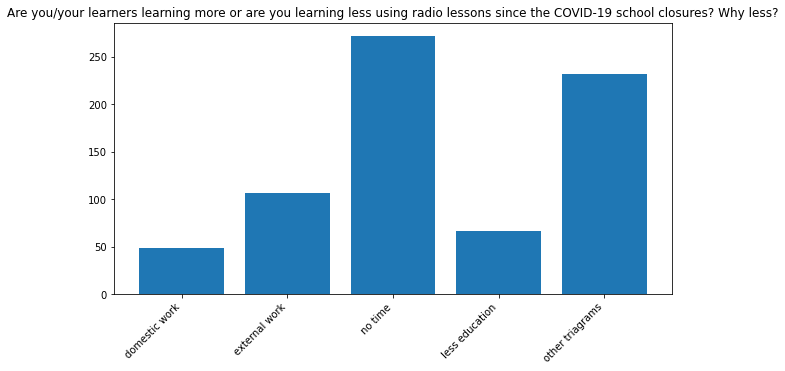

In [188]:
plt.figure(figsize=(10,5))
plt.bar(quantity_learning_less_group.columns, quantity_learning_less_group.sum())
plt.title('Are you/your learners learning more or are you learning less using radio lessons since the COVID-19 school closures? Why less?')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Save vectors and concepts

In [189]:
# tokens
quantity_learning_less_tri.to_csv('data/tokens/quantity_learning_less_yes.csv')
# concepts
quantity_learning_less_group.to_csv('data/concepts/quantity_learning_less_concepts.csv')

### 3.5. What is the quality of the radio lessons? How can the radio lessons be improved?

In [54]:
radio_lessons.notnull().sum()

Unnamed: 0                                        4727
Q57_What is the quality of the radio lessons?     1375
Q58_How can the radio lessons be improved?        1375
dtype: int64

In [55]:
radio_lessons.iloc[:,1].value_counts()

Good         644
Fair         396
Not good     186
Very good    149
Name: Q57_What is the quality of the radio lessons? , dtype: int64

Group 'Good' with 'Very Good' and 'Not good' with 'Fair'

In [220]:
# fair + not good vs 
radio_lessons_good = radio_lessons[(radio_lessons.iloc[:,1] == 'Fair')].iloc[:,2]

In [221]:
radio_lessons_vgood = radio_lessons[(radio_lessons.iloc[:,1] == 'Very Good')].iloc[:,2]

In [222]:
radio_lessons_ngood = radio_lessons[(radio_lessons.iloc[:,1] == 'Not Good')].iloc[:,2]

In [223]:
radio_lessons_fair = radio_lessons[(radio_lessons.iloc[:,1] == 'Fair')].iloc[:,2]

#### Trigram Vectorization
Radio Lessons Good Quality

In [224]:
radio_lessons_good_tri = bow_vectorization(data = radio_lessons_good.dropna(),
                                          index = radio_lessons_good.dropna().index,
                                          n_grams=(3, 3))

752 words in dictionary.


In [225]:
radio_lessons_good_tri.sum().sort_values(ascending=False)[:30]

provide learners radio           8
provide radio learners           7
radio given learners             4
lengthening broadcasting time    4
provide radios learners          4
radio distributed learners       3
distribution solar radios        3
enough time given                3
distribution radios learners     3
broadcasting time etc            2
evening pm pm                    2
local radio stations             2
number hours increase            2
provide radios students          2
provide learners radios          2
increase time lessons            2
teachers guide learner           2
like teachers neare              2
radio lessons improved           2
fine tune radio                  2
languages lower classes          2
programs enough time             2
extension radio coverage         2
unless number hours              2
program local radios             2
strong signal programs           2
uses local languages             2
provision radio learners         2
providing radios stu

#### Group Trigrams
Trigrams about the coverage

In [226]:
coverage = search(['cover','extension','tune'], None, radio_lessons_good_tri.columns)
len(coverage)

17

In [227]:
#improve = search('improv', 'lessons', radio_lessons_good_tri.columns)
#len(improve)

In [243]:
search('time', None, radio_lessons_good_tri.columns)

['add time discussion',
 'added time lessons',
 'allocate enough time',
 'availability time frame',
 'broadcasting time etc',
 'broadcasting time give',
 'broadcasting time provide',
 'enough time given',
 'enough time giving',
 'enough time learners',
 'enough time lesson',
 'enough time radio',
 'give time response',
 'given enough time',
 'given time elaborate',
 'giving enough time',
 'giving many times',
 'improve time children',
 'increase broadcasting time',
 'increase time learners',
 'increase time lessons',
 'increase time period',
 'increase time radio',
 'learner sellect time',
 'learners enough time',
 'least add time',
 'lengthening broadcasting time',
 'lessons given times',
 'lessons many times',
 'need time changed',
 'need time improve',
 'nothing time spell',
 'programs enough time',
 'questioning time learners',
 'radio function time',
 'radio given time',
 'radios availability time',
 'repeated several times',
 'several times easy',
 'sometimes net work',
 'things 

In [228]:
len(search(['powe','energ'],None, radio_lessons_good_tri.columns))

6

Trigrams about the num of radios

In [242]:
provision = search(['prov','dist'], None, radio_lessons_good_tri.columns)
len(provision)

141

Trigrams about content

In [230]:
content = search(['subject', 'time', 'guid'], None, radio_lessons_good_tri.columns)
len(content)

83

Trigrams about speech

In [231]:
language = search(['language','trans'], None, radio_lessons_good_tri.columns)
len(language)

25

In [232]:
speed = search(['speed','repea','unders'], None, radio_lessons_good_tri.columns)
len(speed)

46

Count one per concept apperance (not word)

In [233]:
cover = radio_lessons_good_tri[list(set(coverage + provision))]

In [234]:
content = radio_lessons_good_tri[content]

In [235]:
speech = radio_lessons_good_tri[list(set(language +  speed))]

The rest of the Trigrams

In [236]:
other = radio_lessons_good_tri.drop(cover.columns.to_list() + content.columns.to_list() + speech.columns.to_list(), axis=1)
test_other = radio_lessons_good_tri.drop(cover.columns.to_list() + content.columns.to_list() + speech.columns.to_list(), axis=1)

In [237]:
test_other.columns.to_list()

['access presenter review',
 'account individual differences',
 'added pronouciation adjusted',
 'air lesson radios',
 'allocate enough tmie',
 'allow people listening',
 'also allow people',
 'also bring program',
 'also school reopen',
 'also use arabic',
 'answering question asked',
 'arabic one teaching',
 'areas air lesson',
 'areas strong signal',
 'art section included',
 'ask questions clarification',
 'ask questions words',
 'audios format send',
 'avail radios candidates',
 'base new curriculum',
 'better instead listening',
 'better reopen schools',
 'bring program schools',
 'bringing radio lessons',
 'broadcast local radios',
 'broadcast stations like',
 'broadcasted local radios',
 'brought local radio',
 'building radio lesson',
 'buy radio parents',
 'calling free ask',
 'capacity building radio',
 'cards videos audios',
 'cell radio charging',
 'certain designated centres',
 'chalkboard pupils wants',
 'chance calling free',
 'changed possible late',
 'charging materia

In [210]:
cover = cover.sum(axis=1)
content = content.sum(axis=1)
speech = speech.sum(axis=1)
other = other.sum(axis=1)

In [211]:
cover[cover != 0] = 1
content[content != 0] = 1
speech[speech != 0] = 1
other[other != 0] = 1

In [212]:
coverage = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['enough coverage'])
coverage.loc[cover[cover == 1].index,:] = 1
cont = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['local language'])
cont.loc[content[content == 1].index,:] = 1
form_speech = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['enough understanding'])
form_speech.loc[speech[speech == 1].index,:] = 1
other_w = pd.DataFrame(np.zeros(radio_lessons.shape[0]), dtype=int, columns=['other biagrams'])
other_w.loc[other[other == 1].index,:] = 1

In [213]:
radio_lessons_good_group = pd.concat([coverage, cont, form_speech, other_w], axis=1)

Visualization

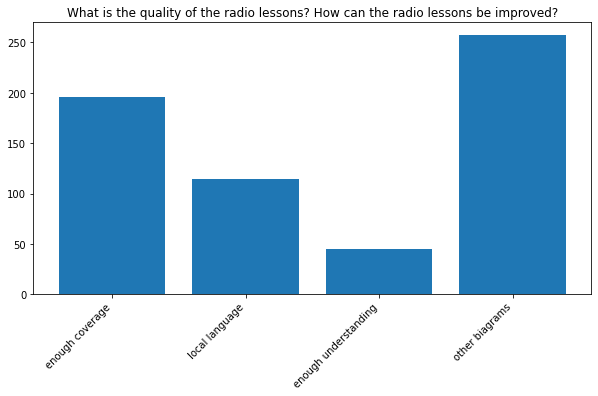

In [214]:
plt.figure(figsize=(10,5))
plt.bar(radio_lessons_good_group.columns, radio_lessons_good_group.sum())
plt.title('What is the quality of the radio lessons? How can the radio lessons be improved?')
plt.xticks(rotation=45, ha='right')
plt.show()

Save vectors

In [210]:
radio_lessons_pos_tri.to_csv('data/tokens/radio_lessons_qual_pos.csv')
radio_lessons_neg_tri.to_csv('data/tokens/radio_lessons_qual_neg.csv')

NameError: name 'radio_lessons_pos_tri' is not defined